ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **07Sep21**

# 02. Fourier Basis Functions Least-Squares Residual
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Gmtrx}{\boldsymbol{\mathsf{G}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [Fourier Basis Functions](#fourier)
* [Basis Functions Evaluation Matrix](#eval-matrix)
* [Collocation Approximation](#coll)
  + [Collocation Points](#coll-pts)
  + [Collocation Matrix](#coll-matrix)
  + [Optimal Combination Coefficients](#coll-optimal-coeff)
  + [Best Approximant Function](#coll-approximant)
  + [Results](#coll-res)
  + [Errors](#coll-error)
  + [Residual](#coll-residual)
* [Continuous Approximation ($m\rightarrow\infty$)](#cont)
  + [Gram Matrix](#gram-matrix)
  + [Load Vector](#load-vector)
  + [Optimal Combination Coefficients](#cont-optimal-coeff)
  + [Best Approximant Function](#cont-approximant)
  + [Results](#cont-res)
  + [Errors](#cont-error)
  + [Residual](#cont-residual)
  + [Comparison to Collocation Method](#cont-comparison)
* [Experiment #1](#ex1)
---

## [Objectives](#toc)<a id="obj"></a>

 + Practical use of Fourier basis functions to approximate a given function via the Galerkin Linear Least-Squares method.
 + Review [Introduction Notebook 01](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/01-introduction.ipynb)

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:[a,b]\rightarrow\Reals$, compute an approximant $g:[a,b]\rightarrow\Reals$.

# shape pts =  12


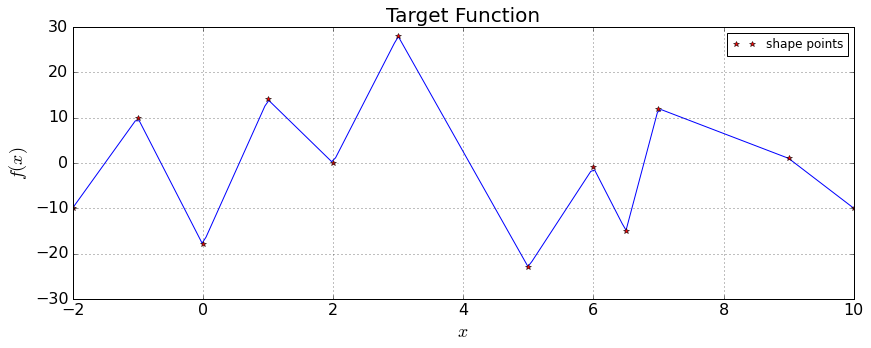

In [1]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10), (-1,10), (0,-18), (1,14), (2,0), (3,28), (5,-23), (6, -1), (6.5, -15), (7,12), (9,1), (10,-10)]
print('# shape pts = ', len(shape_pts))

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

## [Fourier Basis Functions](#toc)<a id="fourier"></a>

Using Fourier basis functions 

\begin{equation*}
   V := \{\cos(k\,\kappa\, x), \,\sin(k\,\kappa\, x)\, \mid \, k=0,\ldots,N\},
\end{equation*}

and the collocation points $\tilde{\xvec}$, compute the best approximant function of $f:\Reals\rightarrow \Reals$ by minimizing the residual vector on the collocation points.

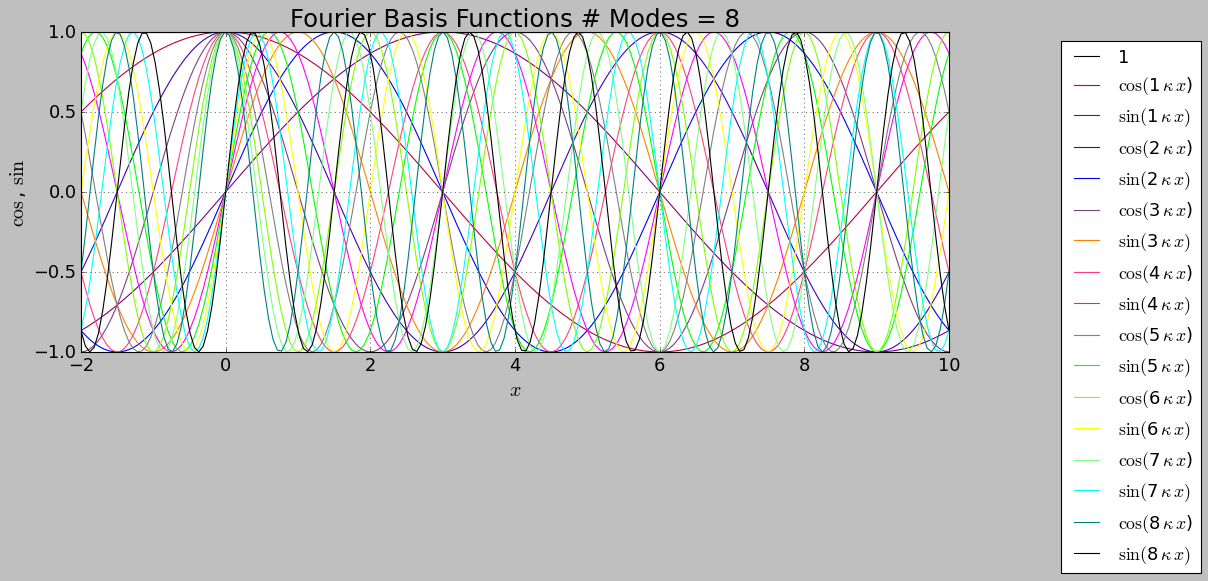

In [2]:
'''Build the basis functions list'''

import math

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

wavelength = x_max - x_min
kappa = 2*math.pi/wavelength

N = 8 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_min, x_max)
fb.plot()

## [Basis Functions Evaluation Matrix](#toc)<a id="eval-matrix"></a>

Build the *basis functions evaluation matrix* $\Amtrx(\xvec)$ as a $m\times n$ real matrix, that is:

$\overset{(m \times n)}{\Amtrx}(\xvec) =  \begin{pmatrix}
1 & \cos(\kappa\,x_1) & \sin(\kappa\,x_1) & \cos(2\kappa\,x_1) & \sin(2\kappa\,x_1) & \ldots & \cos(N\kappa\,x_1) & \sin(N\kappa\,x_1)  \\
1 & \cos(\kappa\,x_2) & \sin(\kappa\,x_2) & \cos(2\kappa\,x_2) & \sin(2\kappa\,x_2) & \ldots & \cos(N\kappa\,x_2) & \sin(N\kappa\,x_2)  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
1 & \cos(\kappa\,x_m) & \sin(\kappa\,x_m) & \cos(2\kappa\,x_m) & \sin(2\kappa\,_m) & \ldots & \cos(N\kappa\,x_m) & \sin(N\kappa\,x_m)  \\
 \end{pmatrix}$

## [Collocation Approximation](#toc)<a id="coll"></a>

### [Collocation Points](#toc)<a id="coll-pts"></a>

Select *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$.

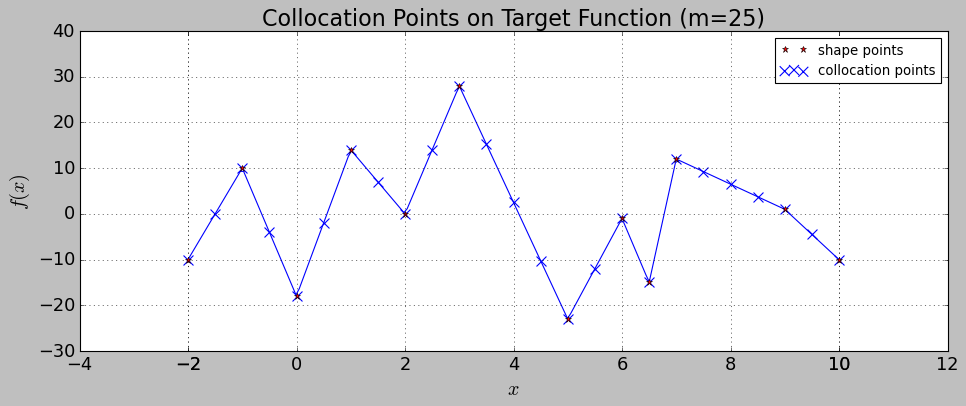

In [3]:
'''Collocation abscissa points'''
import numpy as np

m = 25
assert m >= len(shape_pts)

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, show_shape_pts=True, title='Collocation Points on Target Function (m='+str(m)+')')

### [Basis Functions Collocation Matrix](#toc)<a id="coll-matrix"></a>

Create the *basis functions collocation matrix* by evaluating the basis function evaluation matrix on the collocation points $\tilde{\Amtrx} = \Amtrx(\tilde{\xvec})$.

In [4]:
'''Build the basis functions collocation matrix'''

a_tilde_mtrx = fb.evaluation_matrix(x_tilde_pts)

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is overdetermined.
A is full rank.


In [5]:
'''Build target function vector at the collocation points'''

f_tilde_vec = np.array(f.values(x_tilde_pts))

### [Optimal Combination Coefficients](#toc)<a id="coll-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values (this is not a sufficient condition but a good start). Otherwise the least-squares method for rank-deficient problem must be employed and the shortest, minimal residual 2-norm computed. Therefore everything done to this point depends also on a choice of collocation points $\tilde{\xvec}$. To make this clear, the optimal coefficient vector is denoted $\tilde{\cvec}^*$.

In addition to $\tilde{\cvec}^*$, compute the residual 2-norm

\begin{equation*}
 \norm{\tilde{\rvec}(\tilde{\cvec}^*)}_2 =  \norm{\tilde{\fvec} - \tilde{\Amtrx}\,\tilde{\cvec}^*}_2 ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [6]:
'''Compute optimal coefficient vector'''

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank; solve for least squares.')
    c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient; solve for shortest least squares')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
    
print('')
print('c_tilde_star_vec:\n')
for j,c in enumerate(c_tilde_star_vec):
    if j == 0:
        print('a_%2i = %10.3e'%(j,c))
    elif j%2 == 0:
        k = j/2
        print('b_%2i = %10.3e'%(k,c))
    else:
        k = (j+1)/2
        print('a_%2i = %10.3e'%(k,c))
        
print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank; solve for least squares.

c_tilde_star_vec:

a_ 0 =  9.753e-01
a_ 1 =  2.271e+00
b_ 1 =  3.184e+00
a_ 2 = -7.851e+00
b_ 2 =  6.290e+00
a_ 3 =  1.500e+00
b_ 3 = -7.043e+00
a_ 4 = -3.503e-01
b_ 4 =  1.220e+00
a_ 5 = -5.521e+00
b_ 5 =  2.305e+00
a_ 6 = -5.174e+00
b_ 6 = -1.708e+00
a_ 7 = -3.955e+00
b_ 7 =  1.267e+00
a_ 8 =  1.025e+00
b_ 8 = -2.375e+00

||r^*||_2 =  1.361e+01


### [Best Approximant Function](#toc)<a id="coll-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec_\text{best}(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [7]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = fb.evaluation_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

### [Results](#toc)<a id="coll-res"></a>

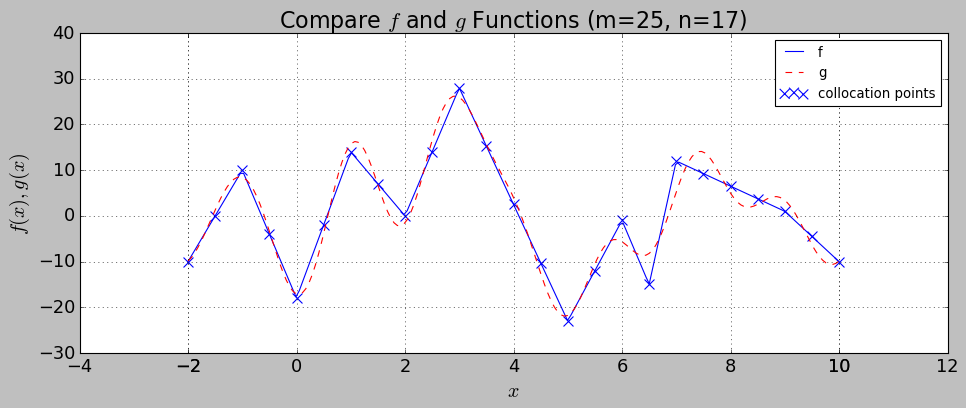

In [8]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_1 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_1), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ Functions (m='+str(m)+', n='+str(len(fb.basis_func_list))+')')

### [Errors](#toc)<a id="coll-error"></a>

Errors are instrumental to judge how good an approximation is. However there is no one absolute strategy to judge the quality of an approximation. Here we list a few possibilities.

**Local errors are too pessimistic.**

In [9]:
'''Local error depends on the number of sampling points'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

f_vec = f.values(x_pts)
g_vec = g_best_vec_func(x_pts)

shift = False

if shift:
    min_val = min(min(f_vec), min(g_vec))
    v_shift = min_val
    f_vec += abs(v_shift+1)
    g_vec += abs(v_shift+1)

print('mean local rel error [%] = ', np.mean(abs((g_vec-f_vec)/f_vec*100.0)))
print('std local rel error [%] = ', np.std(abs((g_vec-f_vec)/f_vec*100.0)))
print('max local rel error [%] = ', np.max(abs((g_vec-f_vec)/f_vec*100.0)))
print('min local rel error [%] = ', np.min(abs((g_vec-f_vec)/f_vec*100.0)))

mean local rel error [%] =  72.66094892889927
std local rel error [%] =  327.7107635635114
max local rel error [%] =  4515.202657719333
min local rel error [%] =  0.029291154218032318


**Area-based error is often misleading.**

In [10]:
'''Area-based error'''

from scipy.integrate import quad

def f_integrand(x):
    return f.values(np.array([x]))
def g_integrand(x):
    return g_best_vec_func(np.array([x]))

f_integral = quad(f_integrand, x_min, x_max, limit=100)
print('Area under f =', f_integral)

g_integral = quad(g_integrand, x_min, x_max, limit=100)
print('Area under g =', g_integral)

print('rel error [%] = ', abs(g_integral[0]-f_integral[0])/f_integral[0]*100)

Area under f = (11.750000000000016, 6.572520305780927e-14)
Area under g = (11.703507766201836, 5.268192992957665e-09)
rel error [%] =  0.3956785855164223


**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [11]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f.values(np.array([x]))
    g_vec = g_best_vec_func(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 36.98197759332081

||g||_L2 = 39.595108852677036

||f-g||_L2 = 8.055621386388006

Relative error [%] = 21.782559805138447


### [Residual](#toc)<a id="coll-residual"></a>

**The residual vector mapping also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives at collocation pts =  11
Negatives at collocation pts =  14
Positives =  116
Negatives =  134


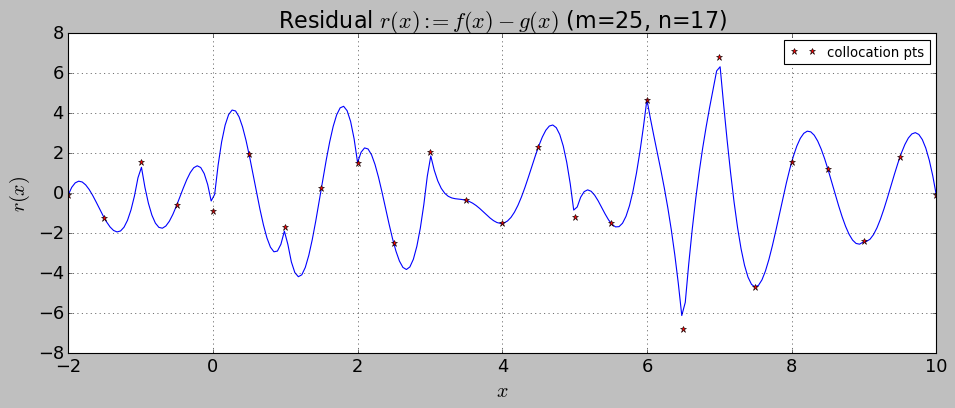

In [12]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (m='+str(m)+', n='+str(len(fb.basis_func_list))+')', fontsize=20)

plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**$\Rightarrow$ Case study:** 
>Try $2N+1 > m$ for a rank deficient case.

## [Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="cont"></a>

### [Gram Matrix](#toc)<a id="gram-matrix"></a>

Build the matrix of inner products of the basis functions, the *Gram matrix* or also called the *mass matrix*: ${(\Gmtrx)}_{i,j} = (\phi_i, \phi_j)$.

In [13]:
'''Build the Gram matrix'''

gram_mtrx = fb.gram_matrix()

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


### [Load Vector](#toc)<a id="load-vector"></a>

Build the load vector ${(\bvec)}_{i} = (f, \phi_i)$ by computing the inner product of $f$ with each basis function member.

In [14]:
'''Build load vector'''

b_vec = np.zeros(len(fb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(fb.basis_func_list):
    (b_vec[i], _) = quad(lambda x: f.values(np.array([x])) * phi_i(x), x_min, x_max, limit=100)

### [Optimal Combination Coefficients](#toc)<a id="cont-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \overset{(n\times n)}{\Gmtrx}\,\cvec^* = \bvec ,
\end{equation*}

which has a unique solution since the Gram matrix, $\Gmtrx$, is always full rank (linear independent basis functions).

In addition to $\cvec^*$, compute the residual $L^2(a,b)$ norm

\begin{equation*}
 \norm{r(\cvec^*)}_{L^2(a,b)} = \norm{f - g(\cvec^*)}_{L^2(a,b)} ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [15]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

### [Best Approximant Function](#toc)<a id="cont-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\cvec^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$.

In [16]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = fb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

### [Results](#toc)<a id="cont-res"></a>

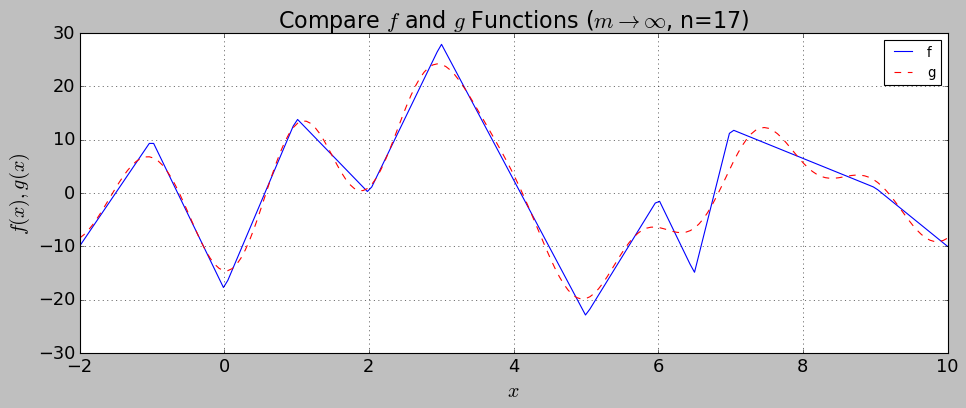

In [17]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(fb.basis_func_list))+')')

### [Errors](#toc)<a id="cont-error"></a>

Errors are measured using functional norms.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [18]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f.values(np.array([x]))
    g_vec = g_best_vec_func(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 36.98197759332081

||g||_L2 = 36.39858741432084

||f-g||_L2 = 6.542896990199725

Relative error [%] = 17.692123071810563


### [Residual](#toc)<a id="cont-residual"></a>

**The residual function also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives at collocation pts =  11
Negatives at collocation pts =  14
Positives =  111
Negatives =  139


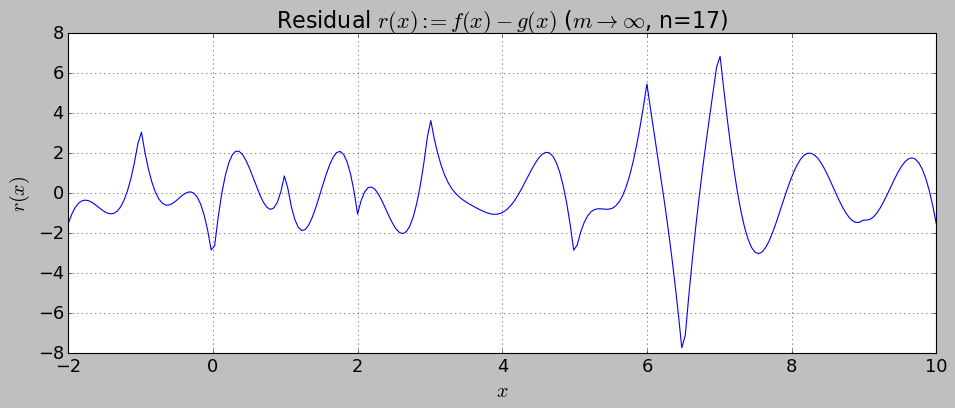

In [19]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ ($m\rightarrow\infty$, n='+str(len(fb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### [Comparison to Collocation Method](#toc)<a id="cont-comparison"></a>

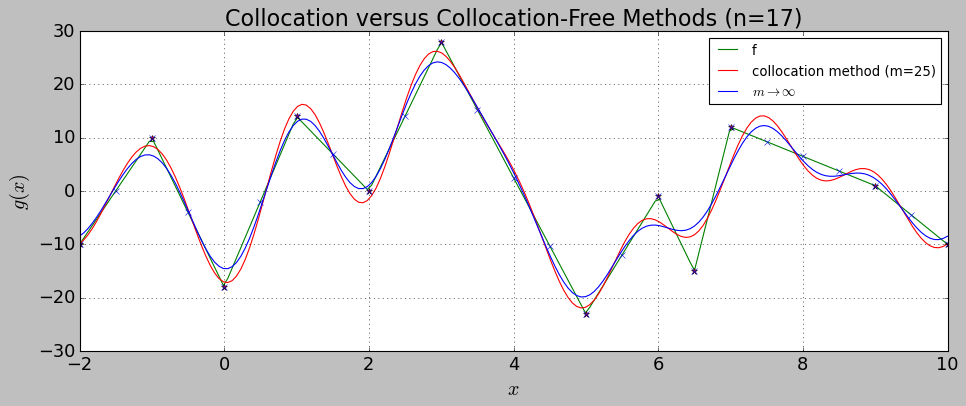

In [20]:
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f.values(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation method (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')

plt.plot([p[0] for p in shape_pts], [p[1] for p in shape_pts],'r*')
plt.plot(x_tilde_pts, f.values(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(fb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

## [Experiment #1](#toc)<a id="ex1"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:(a,b)\in\Reals\rightarrow \Reals$.

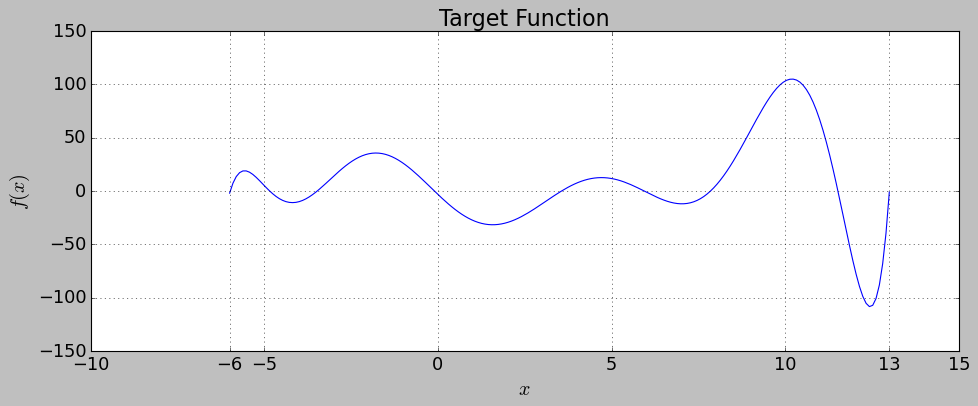

In [21]:
'''Consider another function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-6,-2), (-5,5), (-4,-10), (-3,14), (-1,26), (3,-12), (6, -1), (7, -12), (8,5), (13,-1)]
#print('# shape pts = ', len(shape_pts))
assert len(shape_pts) <= 10

f = TargetFunction(shape_pts, type='legendre')
  
f.plot(n_plot_pts=200, title='Target Function')

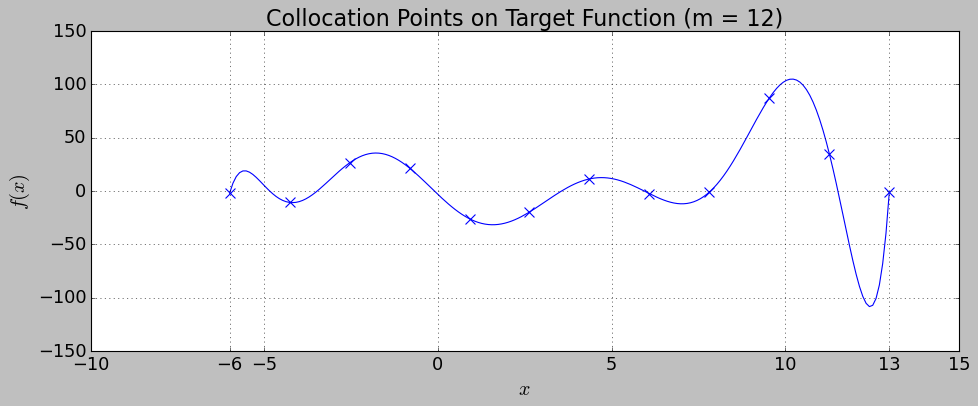

In [22]:
'''Collocation abscissa points'''
import numpy as np

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

m = 12

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, title='Collocation Points on Target Function (m = '+str(m)+')')

In [23]:
'''Build the basis functions'''

import math

wavelength = x_max - x_min
kappa = 2*math.pi/wavelength

N = 3 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_min, x_max)

In [24]:
'''Build the basis function collocation matrix and target function vector at the collocation points'''

a_tilde_mtrx = fb.evaluation_matrix(x_tilde_pts)
f_tilde_vec = np.array(f.values(x_tilde_pts))

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')
    
try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is overdetermined.
A is full rank.


In [25]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank; solve for least squares.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient; solve for shortest least squares')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-7)

print('')
print('c_tilde_star_vec:\n')
for j,c in enumerate(c_tilde_star_vec):
    if j == 0:
        print('a_%2i = %10.3e'%(j,c))
    elif j%2 == 0:
        k = j/2
        print('b_%2i = %10.3e'%(k,c))
    else:
        k = (j+1)/2
        print('a_%2i = %10.3e'%(k,c))
        
print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank; solve for least squares.

c_tilde_star_vec:

a_ 0 =  1.145e+01
a_ 1 = -2.104e+01
b_ 1 = -9.803e+00
a_ 2 =  1.735e+01
b_ 2 = -4.418e+00
a_ 3 = -1.527e+01
b_ 3 = -2.151e+01

||r^*||_2 =  3.540e+01


In [26]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = fb.evaluation_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

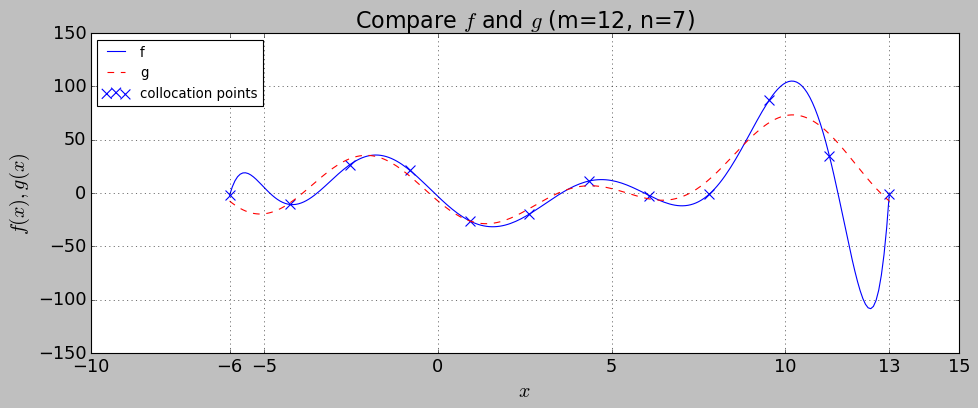

In [27]:
'''Plot comparison of f and g_vec'''

n_pts = max(2*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_1 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_1), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ (m='+str(m)+', n='+str(len(fb.basis_func_list))+')')

In [28]:
'''Relative L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 = %5.2e %5.2e'%f.l2_norm)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=1000)
print('||g||_L2 = %5.2e'%(math.sqrt(g2_integral)))
print('quadrature error = %5.2e'%error)

x_ave = (x_min + x_max)/2
x_length = x_max - x_min

def f_minus_g_2_integrand(x):
    x_hat = 2*(x - x_ave)/x_length
    # single value call must be between -1 and 1
    f_x = f.values(np.array([x_hat]))
    g_vec = g_best_vec_func(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=1000)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 1.77e+02 3.48e-10

||g||_L2 = 1.31e+02
quadrature error = 1.08e-09

||f-g||_L2 = 125.12841520457864
quadrature error = 1.974193412912495e-09

Relative error [%] = 70.70080172237635


Positives at collocation pts =  7
Negatives at collocation pts =  5
Positives =  149
Negatives =  151


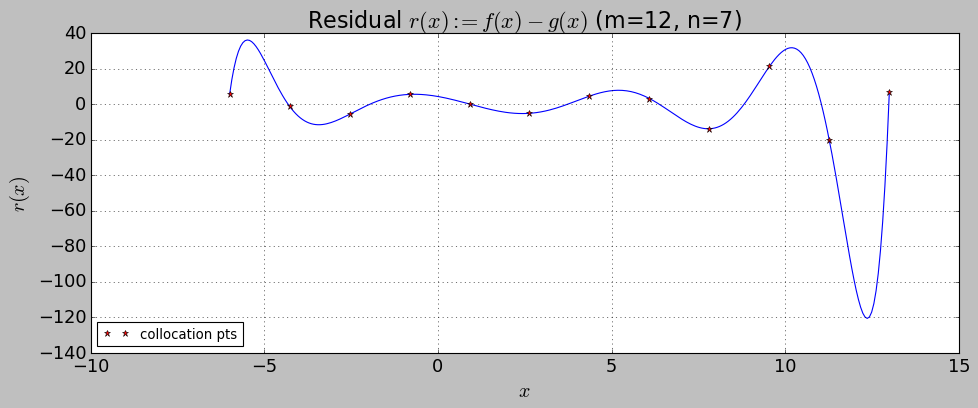

In [29]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(4 * m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (m='+str(m)+', n='+str(len(fb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

In [30]:
'''Build the Gram matrix'''

gram_mtrx = fb.gram_matrix()

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [31]:
'''Build load vector'''

b_vec = np.zeros(len(fb.basis_func_list), dtype=np.float64)

x_ave = (x_min + x_max)/2
x_length = x_max - x_min

#x_hat = 2*(x-x_ave)/x_length
## single value call must be between -1 and 1
    
for i, phi_i in enumerate(fb.basis_func_list):
    (b_vec[i], _) = quad(lambda x: f.values(np.array([2*(x-x_ave)/x_length])) * phi_i(x), x_min, x_max, limit=100)

In [32]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

In [33]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = fb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

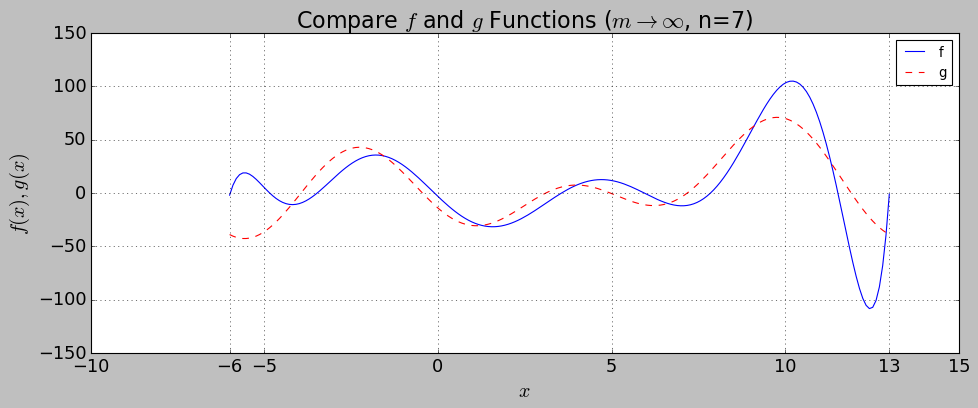

In [34]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(fb.basis_func_list))+')')

In [35]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

x_ave = (x_min + x_max)/2
x_length = x_max - x_min

def g2_integrand(x):
    x_hat = 2*(x-x_ave)/x_length
    # single value call must be between -1 and 1
    g_vec = g_best_vec_func(np.array([x_hat]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    x_hat = 2*(x-x_ave)/x_length
    # single value call must be between -1 and 1
    f_x = f.values(np.array([x_hat]))
    g_vec = g_best_vec_func(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 176.98302162955008

||g||_L2 = 82.65449443614668

||f-g||_L2 = 111.55892955364395

Relative error [%] = 63.03369019608683


Positives =  127
Negatives =  123


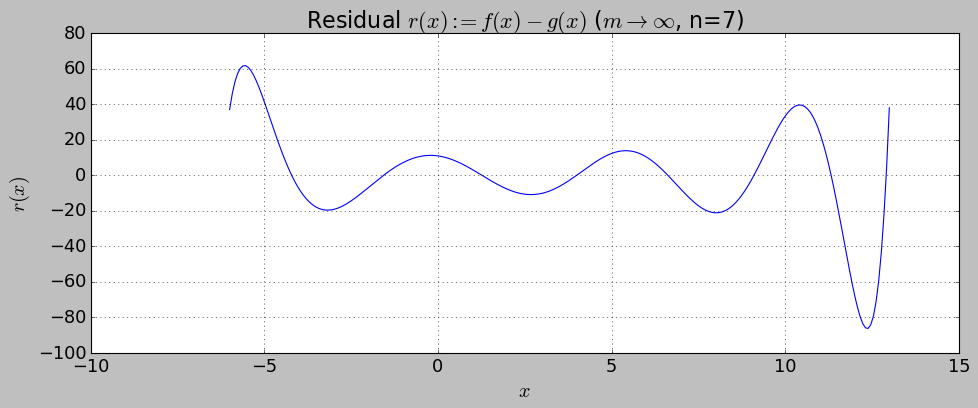

In [36]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ ($m\rightarrow\infty$, n='+str(len(fb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

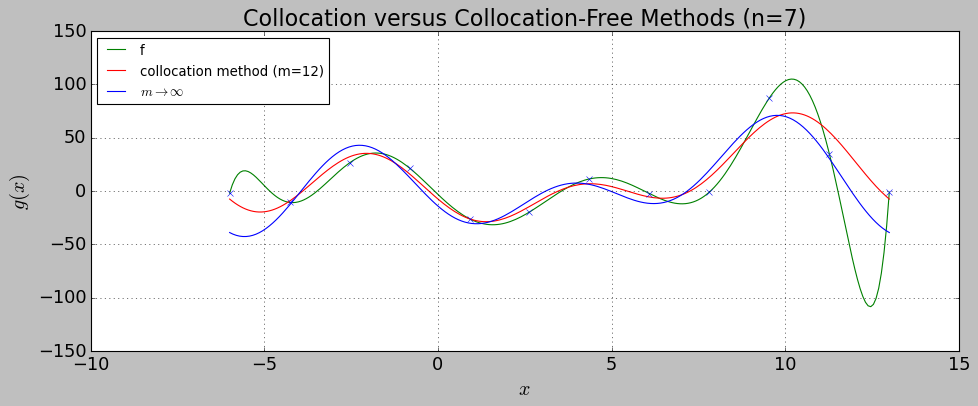

In [37]:
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f.values(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation method (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')

plt.plot(x_tilde_pts, f.values(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(fb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()